# PROHACK 2020
## Bartov Oleg 2020-06-16
### Russia
The notebook contains the solution for the hackaton task

In [1]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.neighbors import KDTree
from sklearn.linear_model import LinearRegression

import lightgbm as lgb
import warnings

from scipy.optimize import linprog
import random

# #1 Data loading

In [2]:
%%time
#train data loading
df = pd.read_csv('train_to_download_final_1.csv',sep=',')
#outlier removing
df = df.loc[df['existence expectancy index'].dropna().index]
#creating of categorical feauture - galaxy code (for train)
le = preprocessing.LabelEncoder()
le.fit(df.galaxy)
df['gal_code'] = le.transform(df.galaxy)
#test column matching
df['test'] = -1

#test data loading
df_test = pd.read_csv('test_to_download_final_1.csv',sep=',')
#index keeping
df_test['test'] = df_test.index
#creating of categorical feauture - galaxy code (for test)
df_test['gal_code'] = le.transform(df_test.galaxy)
df_test['y'] = np.NaN

#sample union
df = df.append(df_test)
#reindex
df.reset_index(inplace = True, drop=True)

Wall time: 104 ms


### I wasted a lot of time to fit the model with full data.
### I cleaned it, I recovered it with regression and clustering, I used a lot of variants such as combinations, PCA, SVD and so on.
# BUT
### The best solution is to use only galaxy code, galactic year and the time series of "y".

# #2 Data preprocessing

## #2.0 Solution "neighbors"
We can find neighbors at the time series of "y". It allows us to create new categorical features and to inherit some information

In [3]:
%%time
df_neighbors = df.pivot(index='gal_code', columns='galactic year', values='y')
df_neighbors.reset_index(inplace=True)
tree = KDTree(df_neighbors.iloc[:,1:17], metric='chebyshev')
dist, ind = tree.query(df_neighbors.iloc[:,1:17], k=8)

#for example
g = 72
print(df[df.gal_code==g].galaxy.min())
print(dist[g])
df_neighbors.iloc[ind[g],13:]

Horologium I
[0.         0.0011362  0.0011911  0.00143109 0.00152781 0.0016845
 0.00170671 0.00173004]
Wall time: 15.9 ms


galactic year,1002001,1003002,1004004,1005006,1006009,1007012,1008016,1009020,1010025,1011030,1012036,1013042,1014049,1015056,1016064
72,0.053734,0.053422,0.053260,0.053008,0.052860,0.052576,0.052344,0.052119,0.051921,0.045180,0.046695,NaN,NaN,0.036743,NaN
71,0.052872,0.052602,0.052502,0.052332,0.051717,0.051490,0.051247,0.051060,0.050867,0.041880,NaN,NaN,0.036686,NaN,NaN
111,0.052728,0.052577,0.052571,0.052507,0.050515,0.050493,0.050491,0.050569,0.050656,0.041859,NaN,NaN,0.036274,0.033304,NaN
99,0.054921,0.054710,0.054636,0.054439,0.053576,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.036725,NaN
176,0.052207,0.051937,0.051811,0.051539,0.050483,0.050084,0.049707,0.049508,0.049184,0.039631,0.040040,NaN,NaN,0.028505,NaN
80,0.055111,0.054623,0.054428,0.054199,0.054419,NaN,NaN,NaN,NaN,NaN,0.048166,0.042270,0.043012,0.039952,NaN
81,0.055374,0.055037,0.054874,0.054571,0.053056,NaN,NaN,NaN,NaN,NaN,0.042340,0.036190,0.038327,0.031976,NaN
105,0.054364,0.053950,0.053981,0.053659,0.051821,0.051471,0.051176,0.050956,0.050714,0.041249,0.041500,0.035373,0.034928,NaN,NaN


## #2.1 Inheritance from neighbors
I had tried several choises before I made this.
But if I had more submissions I would try more options inheritance options

In [4]:
df_answer = pd.DataFrame({'gal_code':[123]*0, 'yr':[1000000]*0, 'gal_code_donor':[321]*0, 'corr':[0.001]*0})
#df_answer = df_answer.append(pd.DataFrame({'gal_code':[3],'yr':[1012036],'gal_code_donor':[115],'corr':[0.001]}))
#df_answer = df_answer.append(pd.DataFrame({'gal_code':[3],'yr':[1013042],'gal_code_donor':[115],'corr':[0.001]}))
#df_answer = df_answer.append(pd.DataFrame({'gal_code':[3],'yr':[1014049],'gal_code_donor':[115],'corr':[0.001]}))
#df_answer = df_answer.append(pd.DataFrame({'gal_code':[7],'yr':[1012036],'gal_code_donor':[152],'corr':[0]}))
#df_answer = df_answer.append(pd.DataFrame({'gal_code':[7],'yr':[1014049],'gal_code_donor':[152],'corr':[0]}))
#df_answer = df_answer.append(pd.DataFrame({'gal_code':[7],'yr':[1015056],'gal_code_donor':[41],'corr':[0]}))
#df_answer = df_answer.append(pd.DataFrame({'gal_code':[8],'yr':[1011030],'gal_code_donor':[169],'corr':[-0.001]}))
#df_answer = df_answer.append(pd.DataFrame({'gal_code':[8],'yr':[1014049],'gal_code_donor':[169],'corr':[-0.001]}))
#df_answer = df_answer.append(pd.DataFrame({'gal_code':[19],'yr':[1011030],'gal_code_donor':[22],'corr':[0.001]}))
#df_answer = df_answer.append(pd.DataFrame({'gal_code':[19],'yr':[1012036],'gal_code_donor':[22],'corr':[0.001]}))
#df_answer = df_answer.append(pd.DataFrame({'gal_code':[19],'yr':[1013042],'gal_code_donor':[22],'corr':[0.001]}))
#df_answer = df_answer.append(pd.DataFrame({'gal_code':[19],'yr':[1014049],'gal_code_donor':[22],'corr':[0.001]}))
#df_answer = df_answer.append(pd.DataFrame({'gal_code':[50],'yr':[1011030],'gal_code_donor':[13],'corr':[0.001]}))
#df_answer = df_answer.append(pd.DataFrame({'gal_code':[59],'yr':[1012036],'gal_code_donor':[159],'corr':[0]}))
#df_answer = df_answer.append(pd.DataFrame({'gal_code':[59],'yr':[1013042],'gal_code_donor':[159],'corr':[0]}))
#df_answer = df_answer.append(pd.DataFrame({'gal_code':[59],'yr':[1014049],'gal_code_donor':[159],'corr':[0]}))
#df_answer = df_answer.append(pd.DataFrame({'gal_code':[59],'yr':[1015056],'gal_code_donor':[159],'corr':[0]}))
#df_answer = df_answer.append(pd.DataFrame({'gal_code':[95],'yr':[1011030],'gal_code_donor':[120],'corr':[0]}))
#df_answer = df_answer.append(pd.DataFrame({'gal_code':[95],'yr':[1014049],'gal_code_donor':[120],'corr':[0]}))
df_answer = df_answer.append(pd.DataFrame({'gal_code':[107],'yr':[1015056],'gal_code_donor':[154],'corr':[-0.1]}))
#df_answer = df_answer.append(pd.DataFrame({'gal_code':[127],'yr':[1012036],'gal_code_donor':[20],'corr':[0.001]}))
#df_answer = df_answer.append(pd.DataFrame({'gal_code':[127],'yr':[1013042],'gal_code_donor':[20],'corr':[0.001]}))

df_answer['gal_code'] = df_answer['gal_code'].astype('int')
df_answer['yr'] = df_answer['yr'].astype('int')
df_answer['gal_code_donor'] = df_answer['gal_code_donor'].astype('int')
df_answer.reset_index(inplace=True)

## #2.2 Inheritance from close years
##### I see that years before 1011030 are almost the same.
##### I see that 1011030, 1012036 years are almost the same.
##### I see that 1013042,1014049 years are almost the same.

In [5]:
%%time
#Do actions with the inheritance from neighbors
for i,row in df_answer.iterrows():
    df.loc[(df.gal_code==row['gal_code'])
          &(df['galactic year']==row['yr'])
                ,'y_inher'] = df.loc[(df.gal_code==row['gal_code_donor'])&(df['galactic year']==row['yr'])
                                    ,'y'].min()+row['corr']
df['y_full'] = df.apply(lambda row:row['y_inher'] if np.isnan(row['y']) else row['y'],axis=1)

#Do actions with the inheritance from close years
cyc_yrs=[1007012,1008016,1009020,1010025,1011030,1012036,1013042,1014049]
for gal in df.galaxy.unique():
    for yr in cyc_yrs:
        y_pred = df[(df.test>-1)&(df['galaxy']==gal)&(df['galactic year']==yr)]['y_full']
        if (len(y_pred)>0)&(np.isnan(y_pred.min())):
            if yr<1011030:
                y_pred = df.loc[(df.galaxy==gal)&(df['galactic year']==1006009),'y_full'].min()
            if yr==1011030:
                y_pred = df.loc[(df.galaxy==gal)&(df['galactic year']==1012036),'y_full'].min()
            if yr==1012036:
                y_pred = df.loc[(df.galaxy==gal)&(df['galactic year']==1011030),'y_full'].min()
            if yr==1013042:
                y_pred = df.loc[(df.galaxy==gal)&(df['galactic year']==1014049),'y_full'].min()
            if yr==1014049:
                y_pred = df.loc[(df.galaxy==gal)&(df['galactic year']==1013042),'y_full'].min()
            df.loc[(df.galaxy==gal)&(df['galactic year']==yr),'y_clone'] = y_pred

df['y_full'] = df.apply(lambda row: row['y_full'] if np.isnan(row['y_clone']) else row['y_clone'],axis=1)

Wall time: 4.31 s


## #2.3 Logarithm
When I had been validating the model I found heteroscedasticity in the data.
So I've decided to predict the logarithm of "y". It is a simple attempt to solve the problem.

In [6]:
df['y_full_ln'] = np.log(df['y_full'])

## #2.4 New features
We can add neighbors (from 2.0) as categorical features

In [7]:
df['c1'] = df.gal_code.apply(lambda x: ind[x,1])
df['c2'] = df.gal_code.apply(lambda x: ind[x,2])
df['c3'] = df.gal_code.apply(lambda x: ind[x,3])

# #3 Prediction
## #3.1 Boosting
1016064 years will be predicted separately by simple regression later.

[250]	training's l2: 0.000111172
[500]	training's l2: 4.18459e-05
[750]	training's l2: 2.19147e-05
[1000]	training's l2: 1.32342e-05
[1250]	training's l2: 8.60185e-06
[1500]	training's l2: 6.03921e-06
[1750]	training's l2: 4.45748e-06
[2000]	training's l2: 3.33548e-06
[2250]	training's l2: 2.59058e-06
[2500]	training's l2: 2.06103e-06
[2750]	training's l2: 1.66575e-06
[3000]	training's l2: 1.34249e-06
[3250]	training's l2: 1.04056e-06
[3500]	training's l2: 7.96804e-07
[3750]	training's l2: 5.82602e-07
[4000]	training's l2: 4.11051e-07
[4250]	training's l2: 3.12939e-07
[4500]	training's l2: 2.45923e-07
[4750]	training's l2: 2.01775e-07
[5000]	training's l2: 1.61142e-07
Wall time: 6.04 s


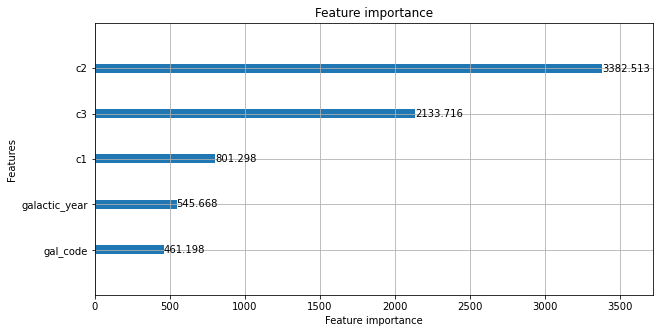

In [8]:
%%time
warnings.filterwarnings('ignore')

#regression parameters was chosen on hyperparameters selection
parameters = {'boosting_type': 'gbdt','objective': 'regression','metric': 'mean_squared_error','num_leaves':29}
#regression columns
light_cols = []
light_cols.append('galactic year')
light_cols.append('c1')
light_cols.append('c2')
light_cols.append('c3')
light_cols.append('gal_code')
cat_cols = ['c1','c2','c3','gal_code']

df['y_predict'] =np.NaN

#define test and train
y_test = df[(df.test!=-1)&(np.isnan(df['y_full']))]['y']
y_train = df[df.y_full_ln<0]['y_full_ln']
X_test = df.loc[y_test.index,light_cols].copy()
X_train = df.loc[y_train.index,light_cols].copy()
ds_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols)
#model fitting
lgb_model = lgb.train(parameters,ds_train,valid_sets=ds_train,categorical_feature=cat_cols,num_boost_round=5000,verbose_eval=250)

#predictions saving (don't forget the logarithm)
df.loc[y_test.index,'y_predict'] = np.exp(lgb_model.predict(X_test))
df['y_total_full'] = df.apply(lambda row: row['y_full'] if np.isnan(row['y_predict']) else row['y_predict'],axis=1)

#print importance
lgb.plot_importance(lgb_model, importance_type='gain', figsize=(10,5))

## #3.2 Linear Regression
Let's try to predict 1016064 separately because trees make it equal with 1015056

In [9]:
lm = LinearRegression()
for gal in df.galaxy.unique():
    X_train = df[(df.galaxy==gal)&(df['galactic year']<1016064)&(df['galactic year']>=1011030)][['galactic year']]
    y_train = list(df.loc[X_train.index,'y_total_full'])
    lm.fit(X_train,y_train)
    if len(df[(df.galaxy==gal)&(df['galactic year']==1016064)])>0:
        df.loc[(df.galaxy==gal)&(df['galactic year']==1016064),'y_total_full'] = lm.predict([[1016064]])

# #4 Optimization
I was trying to use robust linear programming, but I couldn't write code for it.

So I have invented the "sample approach" on usuall linprog.
It uses errors from the strong validation model where they were around 0.015

In [10]:
%%time
#separate dataframe forming
df_test = df[df.test>-1][['galactic year'
                         ,'galaxy'
                         ,'existence expectancy index'
                         ,'y_total_full'
                         ,'test'
                        ]].copy()
df_test['low_ind'] = df_test['existence expectancy index'].apply(lambda x: 1 if x<0.7 else 0)
df_test['potent0'] = -np.log(df_test['y_total_full']+0.01)+3
#std error calculation that was seen on validation
df_test['std_err'] = 0.015

#zero-optimization
c = list(-df_test['potent0']**2/1000)
A_eq, b_eq  = [[1]*len(c)], [50000]
A_ub, b_ub = [list(-df_test['low_ind'])], [-5000]
res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,100), method='interior-point')
df_test['opt0'] = np.round(res.x,0)

#random-optimization
random.seed()
cols = ['test','galactic year','galaxy','low_ind','y_total_full','std_err','opt0']
df_iter = df_test[cols].copy()

for i in range(1,11111):
    if i%50==0:
        print(i)

    for j in df_iter.index:
        y = df_iter.loc[j,'y_total_full']
        se = df_iter.loc[j,'std_err']
        y_smooth = y+random.uniform(-se, se)
        
        df_iter.loc[j,'y_iter'+str(i)] = y_smooth if y_smooth>0 else 0.001
    df_iter['potent'+str(i)] = -np.log(df_iter['y_iter'+str(i)]+0.01)+3

    
    #optimization on the iteration
    c = list(-df_iter['potent'+str(i)]**2/1000)
    A_eq, b_eq  = [[1]*len(c)], [50000]
    A_ub, b_ub = [list(-df_iter['low_ind'])], [-5000]
    res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,100), method='interior-point')
    df_iter['opt'+str(i)] = np.round(res.x,0)
    cols.append('opt'+str(i))

#average processing
df_iter['opt_mean'] = df_iter[cols].iloc[:,6:].mean(axis=1)

#sum correcting because of average
while df_iter['opt_mean'].sum()>50000:
    df_iter.loc[df_iter.test==0,'opt_mean'] = df_iter.loc[df_iter.test==0,'opt_mean']-0.01
    print('correcting')

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
9900
9950
10000
10050
10100
10150
1

# #5 Submisson

In [11]:
df_sub = pd.DataFrame({'index':df_iter['test']
                      ,'pred':df_iter['y_total_full']
                      ,'opt_pred':np.round(df_iter['opt_mean'],3)
                      })
print(df_sub.opt_pred.sum())
df_sub.to_csv('BartovPROHACK.csv', index=False)

50000.00399999999
